# Setup

In [ ]:
import torch
import requests
import numpy as np
import torchvision
import torchvision.transforms as T
import torchvision.models as models
import torch.nn.functional as F
from torch import nn
from PIL import Image
from io import BytesIO
from matplotlib import cm
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from IPython.display import display, clear_output, HTML
from base64 import b64encode
from tqdm.notebook import tqdm
from simpleca import SimpleCA
from fastcore.all import *
from miniai.learner import *

def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

In [ ]:
# Setting device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).to(device).features

def calc_styles(imgs):
    style_layers = [1, 6, 11, 18, 25]  
    mean = torch.tensor([0.485, 0.456, 0.406])[:,None,None].to(device)
    std = torch.tensor([0.229, 0.224, 0.225])[:,None,None].to(device)
    x = (imgs-mean) / std
    grams = []
    for i, layer in enumerate(vgg16[:max(style_layers)+1]):
        x = layer(x)
        if i in style_layers:
            h, w = x.shape[-2:]
            y = x.clone()
            gram = torch.einsum('bchw, bdhw -> bcd', y, y) / (h*w)
            grams.append(gram)
    return grams

def calc_style_loss(grams_x, grams_y):
    loss = 0.0
    for x, y in zip(grams_x, grams_y):
        loss = loss + (x-y).square().mean()
    return loss

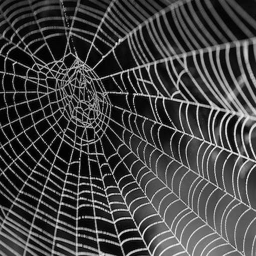

In [ ]:
style_image = download_image("https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?auto=compress&cs=tinysrgb&w=512")
style_image = style_image.resize((256, 256))
style_image

In [ ]:
style_img_tensor = T.ToTensor()(style_image).unsqueeze(0).to(device)
with torch.no_grad():
    style_grams = calc_styles(style_img_tensor)
[g.shape for g in style_grams]

[torch.Size([1, 64, 64]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 256, 256]),
 torch.Size([1, 512, 512]),
 torch.Size([1, 512, 512])]

In [ ]:
ca = SimpleCA(device)

with torch.no_grad():
    x = ca.seed(1) # Starting grid
    x = ca(x) # One iteration of the NCA applied
    outputs = ca.to_rgb(x) # Convert to RGB
    output_grams = calc_styles(outputs) # Get style features

calc_style_loss(style_grams, output_grams) # Loss

tensor(424.3596, device='cuda:0')

In [ ]:
class DummyDataset(Dataset):
    def __init__(self, length=1, x=0, y=0): store_attr('length,x,y')
    def __len__(self): return self.length
    def __getitem__(self, idx): return self.x, self.y

def get_dummy_dls(length=100):
    dl = DataLoader(DummyDataset(length=length), batch_size=1)
    valid_dl = DataLoader(DummyDataset(length=1), batch_size=1)
    return DataLoaders(dl, valid_dl)

In [ ]:
??TrainCB

In [ ]:
class NCACB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, ca, style_img_tensor, style_loss_scale=0.1, size=256, step_n_min=32, step_n_max=96):
        store_attr()
        with torch.no_grad():
            self.style_target_grams = calc_styles(style_img_tensor)
            self.pool = ca.seed(256, sz=size) # Set up a 'pool' of grids
    
    def predict(self, learn): 
        
        # Pick some random samples from the pool
        batch_idx = np.random.choice(len(self.pool), 4, replace=False)
        x = self.pool[batch_idx]
        
        # occasionally zero out some samples
        if np.random.randint(8) == 1: 
            x[:1] = self.ca.seed(1, sz=self.size)
        
        # Apply the model a number of times
        for _ in range(np.random.randint(self.step_n_min, self.step_n_max)):
            x = self.learn.model(x)
        
        # Update pool
        with torch.no_grad(): self.pool[batch_idx] = x
        
        # and store preds
        learn.preds = x
        
    def get_loss(self, learn): 
        output_grams = calc_styles(learn.model.to_rgb(self.learn.preds))
        overflow_loss = (self.learn.preds-self.learn.preds.clamp(-1.0, 1.0)).abs().sum()
        style_loss = self.learn.loss_func(output_grams, self.style_target_grams)
        learn.loss = overflow_loss + style_loss*self.style_loss_scale
        
    def backward(self, learn):
        learn.loss.backward()
        # Gradient normalization
        for p in learn.model.parameters():
            p.grad /= (p.grad.norm()+1e-8) 
        
    def before_fit(self, learn): self.learn=learn 
        
    

In [ ]:
model = SimpleCA(device)
cbs = [NCACB(model, style_img_tensor), ProgressCB(), MetricsCB()]
learn = Learner(model, get_dummy_dls(600), calc_style_loss, lr=1e-3, cbs=cbs, opt_func=torch.optim.Adam)

In [ ]:
learn.fit(1)

loss,epoch,train
77230464.000,0,train
20.880,0,eval


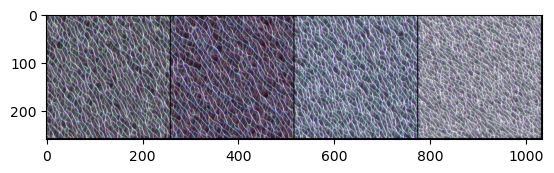

In [ ]:
# Check out the final batch
rgb = model.to_rgb(learn.preds.detach())
rgb = torchvision.utils.make_grid(rgb)
plt.imshow(rgb.permute(1, 2, 0).cpu().clip(0, 1));

In [ ]:
# Interactive view of the result! (A little glitchy)
HTML(model.to_html())

In [ ]:
# n_iter = 1500
# style_loss_scale = 0.1
# lr = 1e-3

# ca = SimpleCA(device)
# opt = torch.optim.Adam(ca.parameters(), lr)
# loss_log = []

# # Set up a 'pool' of grids
# with torch.no_grad():
#   pool = ca.seed(256)

# # Live output
# fig, axs = plt.subplots(1, 2, figsize=(16, 6))
# figure_display = display(fig,display_id=True)

# #training loop 
# for i in range(n_iter):
#   with torch.no_grad():
#     batch_idx = np.random.choice(len(pool), 4, replace=False)
#     x = pool[batch_idx]
#     if i%8 == 0:
#       x[:1] = ca.seed(1)
#   step_n = np.random.randint(32, 96)
#   x = torch.utils.checkpoint.checkpoint_sequential([ca]*step_n, 16, x)
#   imgs = ca.to_rgb(x)
#   styles = calc_styles(imgs)
#   overflow_loss = (x-x.clamp(-1.0, 1.0)).abs().sum()
#   loss = overflow_loss
#   loss += style_loss_scale*calc_style_loss(style_grams, styles)
  
#   with torch.no_grad():
#     loss.backward()
#     for p in ca.parameters():
#       p.grad /= (p.grad.norm()+1e-8)   # normalize gradients 
#     opt.step()
#     opt.zero_grad()
#     pool[batch_idx] = x                # update pool
    
#     loss_log.append(loss.item())

        
#     if i%64==0:
#       if i<1:
#         clear_output(True)
#       else:
#         axs[0].clear()
#         axs[0].plot(loss_log, '.', alpha=0.3)
#         axs[0].set_yscale('log')
#         axs[0].set_ylim(np.min(loss_log), loss_log[0])
#       output_ims = imgs.clip(0, 1).permute([0, 2, 3, 1]).cpu()
#       axs[1].imshow(np.hstack(output_ims))
#       figure_display.update(fig)
#     if i%5 == 0:
#       print('\rstep_n:', i, ' loss:', loss.item(), end='')

# clear_output()